<a href="https://colab.research.google.com/github/k4zuy/Rep-Baal-Progress/blob/main/Augmented/baal_image_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Mon Dec 12 15:34:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!git clone https://github.com/ColinS97/BaaL_Experiments.git

Cloning into 'BaaL_Experiments'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 156 (delta 92), reused 113 (delta 49), pack-reused 0
Receiving objects: 100% (156/156), 172.19 KiB | 13.25 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [4]:
cd BaaL_Experiments

/content/BaaL_Experiments


In [5]:
!pip install baal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 286 kB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 9.4 MB 37.8 MB/s 
     |████████████████████████████████| 4.5 MB 49.6 MB/s 
     |████████████████████████████████| 419 kB 64.2 MB/s 
     |████████████████████████████████| 295 kB 63.3 MB/s 
     |████████████████████████████████| 965 kB 59.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [6]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Required for Nvidia RTX 3060

In [7]:
#python -m pip install torch==1.13.0+cu117 torchvision==0.14.0+cu117 -f https://download.pytorch.org/whl/torch_stable.html

Required for Colab

In [8]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 6.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
baal 1.7.0 requires matplotlib<4.0.0,>=3.4.3, but you have matplotlib 3.1.3 which is incompatible.


Imports

In [9]:
import argparse
import random
import csv
from copy import deepcopy
from time import time
import datetime
from dataclasses import dataclass
import numpy as np
import PIL
import matplotlib.pyplot as plt

import torch
import torch.backends
from torch import optim
from torch.hub import load_state_dict_from_url
from torch.nn import CrossEntropyLoss
from torchvision import datasets
from torchvision.models import vgg16
from torchvision.transforms import transforms
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F

from baal.active import get_heuristic, ActiveLearningDataset
from baal.active.active_loop import ActiveLearningLoop
from baal.bayesian.dropout import patch_module
from baal import ModelWrapper
from baal.utils.metrics import Accuracy
from baal.active.heuristics import BALD
from baal.active.dataset import ActiveLearningDataset

import aug_lib

from baal_extended.ExtendedActiveLearningDataset import ExtendedActiveLearningDataset

In [10]:
@dataclass
class ExperimentConfig:
    epoch: int = 1
    batch_size: int = 32
    initial_pool: int = 1000
    query_size: int = 100
    lr: float = 0.001
    heuristic: str = 'bald'
    iterations: int = 40
    training_duration: int = 10

In [11]:
def get_datasets(initial_pool):
    transform = transforms.Compose(
        [
            #transforms.Resize((224, 224)),
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(30),
            transforms.ToTensor(),
            #transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    test_transform = transforms.Compose(
        [
            #transforms.Resize((224, 224)),
            transforms.ToTensor(),
            #transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    # Note: We use the test set here as an example. You should make your own validation set.
    train_ds = datasets.CIFAR10(
        ".", train=True, transform=transform, target_transform=None, download=True
    )
    test_set = datasets.CIFAR10(
        ".", train=False, transform=test_transform, target_transform=None, download=True
    )

    active_set = ActiveLearningDataset(train_ds, pool_specifics={"transform": test_transform})

    # We start labeling randomly.
    active_set.label_randomly(initial_pool)
    return active_set, test_set

In [12]:
hyperparams = ExperimentConfig()
use_cuda = torch.cuda.is_available()
torch.backends.cudnn.benchmark = True
random.seed(1337)
torch.manual_seed(1337)
if not use_cuda:
    print("warning, the experiments would take ages to run on cpu")

# Get datasets
active_set, test_set = get_datasets(hyperparams.initial_pool)#,2)

# Get our model.
heuristic = get_heuristic(hyperparams.heuristic)
criterion = CrossEntropyLoss()
model = vgg16(num_classes=10)

# change dropout layer to MCDropout
model = patch_module(model)

if use_cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=hyperparams.lr, momentum=0.9)

# Wraps the model into a usable API.
model = ModelWrapper(model, criterion)

# for ActiveLearningLoop we use a smaller batchsize
# since we will stack predictions to perform MCDropout.
active_loop = ActiveLearningLoop(active_set,
                                 model.predict_on_dataset,
                                 heuristic,
                                 hyperparams.query_size,
                                 batch_size=1,
                                 iterations=hyperparams.iterations,
                                 use_cuda=use_cuda,
                                 verbose=False)

# We will reset the weights at each active learning step so we make a copy.
init_weights = deepcopy(model.state_dict())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [13]:
print(active_set.n_labelled)
print(active_set.n_unlabelled)

1000
49000


In [14]:
pool = active_set.pool
indices = np.arange(len(pool))
indices

array([    0,     1,     2, ..., 48997, 48998, 48999])

In [21]:
probs = model.predict_on_dataset(pool,batch_size=10,iterations=20,use_cuda=use_cuda)

[77-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:232] 2022-12-12T15:41:07.466247Z [info     ] Start Predict                  dataset=49000
100%|██████████| 4900/4900 [03:22<00:00, 24.25it/s]


In [16]:
to_label, uncertainty = heuristic.get_ranks(probs) 
to_label = indices[np.array(to_label)]

In [22]:
print(uncertainty)
print(to_label)

[4.2915344e-05 8.4877014e-05 7.4863434e-05 ... 6.9856644e-05 1.0943413e-04
 6.6041946e-05]
[41785 37039 14146 ... 43347 42970 27039]


In [23]:
# größte uncertainty 
# (ix_global_img sowieso in to_label[0] aber for-Schleife für besseres Verständnis)
# also to_label[0] == uncertainty[ix_global_img]
u = 0
ix_pool_img = 0
for i in range(len(uncertainty)):
  if(uncertainty[i]>u): 
    u = uncertainty[i]
    ix_pool_img = i

print("größte uncertainty: " + str(u))
print("dazugehöriger Index: " + str(ix_pool_img))

größte uncertainty: 0.00019621849
dazugehöriger Index: 41785


In [19]:
# größter index
l = 0
for i in range(len(to_label)):
  if(to_label[i]>l): l = to_label[i]

l

48999

In [20]:
oracle_set_one = active_set._pool_to_oracle_index([104559])
print(oracle_set_one)
oracle_set_two = active_set._pool_to_oracle_index(to_label)
print(oracle_set_two[0])
#ix_global_img = oracle_set[0]
#ix_global_img


IndexError: ignored

In [47]:
oracle_set = active_set._pool_to_oracle_index(to_label)
ix_global_img = oracle_set[6786]
ix_pool_img = to_label[6786]

pool_img = active_set.pool[ix_pool_img]
global_img = active_set._dataset[ix_global_img]

In [51]:
print(len(oracle_set))
print(len(to_label)) 

49000
49000


In [59]:
for i in range(len(oracle_set)):
  print(f"i: {i}")
  ix_global_img = oracle_set[i]
  ix_pool_img = to_label[i]
  pool_img = active_set.pool[ix_pool_img]
  global_img = active_set._dataset[ix_global_img]

  compare = torch.eq(global_img[0],pool_img[0])

  for j in range(0,2):
      for l in range(0,31):
          for k in range(0,31):
              if compare[j][l][k] == False:
                  print(f"compare[{j}][{l}][{k}]")
                  input("ABWEICHUNG!")

  print("keine Abweichung")

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
i: 46500
keine Abweichung
i: 46501
keine Abweichung
i: 46502
keine Abweichung
i: 46503
keine Abweichung
i: 46504
keine Abweichung
i: 46505
keine Abweichung
i: 46506
keine Abweichung
i: 46507
keine Abweichung
i: 46508
keine Abweichung
i: 46509
keine Abweichung
i: 46510
keine Abweichung
i: 46511
keine Abweichung
i: 46512
keine Abweichung
i: 46513
keine Abweichung
i: 46514
keine Abweichung
i: 46515
keine Abweichung
i: 46516
keine Abweichung
i: 46517
keine Abweichung
i: 46518
keine Abweichung
i: 46519
keine Abweichung
i: 46520
keine Abweichung
i: 46521
keine Abweichung
i: 46522
keine Abweichung
i: 46523
keine Abweichung
i: 46524
keine Abweichung
i: 46525
keine Abweichung
i: 46526
keine Abweichung
i: 46527
keine Abweichung
i: 46528
keine Abweichung
i: 46529
keine Abweichung
i: 46530
keine Abweichung
i: 46531
keine Abweichung
i: 46532
keine Abweichung
i: 46533
keine Abweichung
i: 46534
keine Abweichung
i: 46535
keine Abweichu

In [37]:

#global_img = active_set._dataset[ix_global_img]

In [ ]:
print(pool_img)

In [ ]:
tensors_global = []
tensors_pool = []

for i in range(2):
  pool_img = active_set.pool[ix_pool_img]
  global_img = active_set._dataset[ix_global_img]
  tensors_pool.append(pool_img)
  tensors_global.append(global_img)


print(torch.eq(tensors_pool[0][0],tensors_pool[1][0]))
print(torch.eq(tensors_global[0][0],tensors_global[1][0]))

In [38]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        #axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Bilder mit Normalisierung -> verzerrte Farben

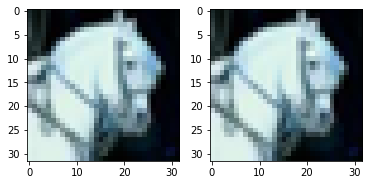

In [48]:
show((pool_img[0],global_img[0]))

In [45]:
torch.eq(global_img[0],pool_img[0])

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]]

In [49]:

compare = torch.eq(global_img[0],pool_img[0])

for i in range(0,2):
  for l in range(0,31):
    for k in range(0,31):
      if compare[i][l][k] == False:
        print(f"compare[{i}][{l}][{k}]")

In [ ]:
torch.abs(global_img[0] - pool_img[0])

In [ ]:
plt.imshow(pool_img[0].permute(1, 2, 0).numpy())

In [ ]:
plt.imshow(global_img[0].permute(1, 2, 0).numpy())

Normalisierung umgekehrt

In [ ]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],std = [ 1., 1., 1. ]),
                               ])

In [ ]:
show((invTrans(pool_img[0]),invTrans(global_img[0])))

In [ ]:
plt.imshow(invTrans(pool_img[0]).permute(1, 2, 0).numpy())

In [ ]:
plt.imshow(invTrans(global_img[0]).permute(1, 2, 0).numpy())

In [ ]:
torch.eq(invTrans(pool_img[0]),invTrans(global_img[0]))

In [ ]:
torch.abs(invTrans(pool_img[0]) - invTrans(global_img[0]))

Versuche herauszufinden was folgende Zeile genau macht und wieso aber bisher erfolglos

In [ ]:
to_label_two = indices[np.array(to_label)]
to_label_two

In [ ]:
print(type(to_label))
print(type(to_label_two))
print(len(to_label))
print(len(to_label_two))

In [ ]:
indices[np.array(to_label)]

In [ ]:
t = np.array([3,7,1,4])
t